# MNIST Classifier

In this tutorial, we are going to build a neural network that can classify handwritten digits (0-9)! Does that sound exciting? Probabbly not in this problem domain. However the principles we are going to apply in handwritten digit recognition are equally valid to other visual recognition challanges. Would you like to build a 1000 class image classifier? Are you developing an automated vehicle? Do you want to replicate the human visual system? Read on.

*Disclaimer: the latter two objectives are far more complicated than this tutorial makes vision seem to be. It is almost abusive to consider human vision as simple as convolution.*

### Notice and Copyright

This tutorial was written to complete the Quiz 14 and Assignment 1 requirement of Data Mining:

> Your goal is building CIFAR-10 image classifier. (Assignment 1)

> Complete the MNIST Classifier shown in class and submit the code+output screenshot.
> 
> Change the network to contain 4 convolution layers with 6, 32, 64, 16 layers, and 3 fully connected layers with 256, 64, 10 nodes in each layer respectively.
> 
> Use sigmoid activation in all layers except the output layer.
> (Quiz 14)

All comments and code were written from memory. No papers, books, Google, stack overflow, or Internet unless noted.

Copyright &copy; Jacob Valdez 2021. Released under MIT License.

## Getting Started

As you start to explore github, you'll observe a few common nicknames that we give our packages. I'm just going to import my default go-to's for now:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as display

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfkl
import tensorflow.keras.datasets as datasets

## The Data

Let's load the `mnist` dataset and observe a few elements.

11501568/11490434 [==============================] - 2s 0us/step


5

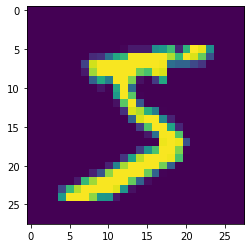

0

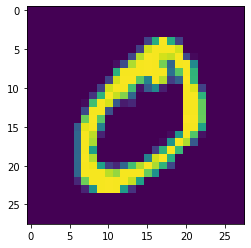

4

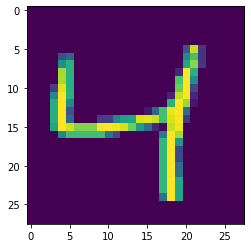

1

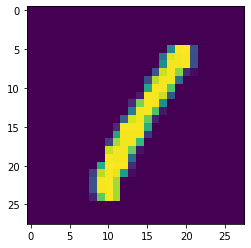

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [2]:
(X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()

for i in range(4):
    plt.imshow(X_train[i])
    display.display(Y_train[i])
    plt.show()

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Notice that each number has an image (stored in `X_train/test`) and a label (stored in `Y_train/test`) Each image is 28 by 28 pixels and there are 60000 training examples and 10000 test examples. Note that this dataset is supplied in integers so I'm going to convert it to floating point representation for our neural network:

In [3]:
print('before', X_train.dtype)
X_train, X_test = X_train/255., X_test/255.
print('after', X_train.dtype)

before uint8
after float64


## The Classifier

We're just going to build a plain-old Convolutional Neural Network. The idea of performing convolutions is that not every part of an images has information pertaining to every other part. As we analyze a scene, we can often decompose the visual information relationships into a spatially segmented hierarchy. Convolutional neural networks carry this inductive bias by performing a miniature perceptron operation at every receptive field location in an image. Unless commented below, we'll use keras's default implementations to achieve this:  

In [4]:
model = keras.Sequential([
    tfkl.Input(shape=(28, 28)),
    tfkl.Reshape(target_shape=(28, 28, 1)),  # give each pixel a 1 dimensional channel
    tfkl.Conv2D(filters=6, kernel_size=(3,3), activation='sigmoid'),
    tfkl.Conv2D(filters=32, kernel_size=(3,3), activation='sigmoid'),
    tfkl.Conv2D(filters=64, kernel_size=(3,3), activation='sigmoid'),
    tfkl.Conv2D(filters=16, kernel_size=(3,3), activation='sigmoid'),
    tfkl.GlobalMaxPooling2D(),  # this layer will take the highest value features over all pixels for each of the 16 filters
    tfkl.Dense(256, activation='sigmoid'),
    tfkl.Dense(64, activation='sigmoid'),
    tfkl.Dense(10),
])

## Training

Next, we're goign to train our classifier. Since the data is supplied with integer labels but our model outputs probabilities over 10 classes, we cannot directly differentiate between the two without either
- converting `y_train` and `y_test` integer labels into one-hot encodings or
- using a sparse categorical loss function.

I select the latter option for computational and information theoretic reasons. Cross entropy $H(p,q)$ represents the expected amount of extra information needed to encode some code under an existing distribution. Formally, $$H(p,q)=E_{x \sim p(x)}[-\log{q(x)}]$$
This is ideal when our model serves as the posterier $q(x,y)$ and the dataset as the prior $p(x,y)$. Our loss function will then be the sparse categorical cross entropy between our model's estimates and the dataset labels. Keras provides a high level interface to implement this in the `model.compile` function:

In [5]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        1760      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 16)        9232      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               4

Now it's time to actually train the model. Let's supply our training a testing data and see how training progresses:

In [6]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=64,
    epochs=10,
    verbose=2,
    validation_data=(X_test, Y_test),
    validation_batch_size=64,
)

Epoch 1/10
938/938 - 103s - loss: 2.3093 - val_loss: 2.3037
Epoch 2/10
938/938 - 100s - loss: 2.3040 - val_loss: 2.3022
Epoch 3/10
938/938 - 105s - loss: 2.3028 - val_loss: 2.3025
Epoch 4/10
938/938 - 100s - loss: 2.3022 - val_loss: 2.3018
Epoch 5/10
938/938 - 99s - loss: 2.3020 - val_loss: 2.3020
Epoch 6/10
938/938 - 98s - loss: 2.3020 - val_loss: 2.3026
Epoch 7/10
938/938 - 97s - loss: 2.3020 - val_loss: 2.3019
Epoch 8/10
938/938 - 96s - loss: 2.3019 - val_loss: 2.3013
Epoch 9/10
938/938 - 98s - loss: 2.3018 - val_loss: 2.3015
Epoch 10/10
938/938 - 98s - loss: 2.3017 - val_loss: 2.3012


What's happening? The loss isn't improving. 

Why can't we just plug and chug whatever data we want into our model? Consider two reasons:
1) There is no globally optimal universal approximator, and specialized models such as this CNN may not have sufficient inductive priors to estimate their data generating distribution
2) Sigmoid-type activation functions saturate the gradients relatively easily. This means that when the input is large in the positive or negative extrema, gradients are effectively zero. During backpropagation, the gradients hardly penetrate the top layer and only slowly penetrate lower and lower into the model. (See the paper that introduced batch norm and *The Principles of Deep Learning Theory* for a longer discussion of these points.)

We can solve this problem by changing our activation function to something that is still nonlinear but allows gradients to flow faster over the epochs. My go-to activation function is the rectified linear unit `relu`:

In [7]:
model = keras.Sequential([
    tfkl.Input(shape=(28, 28)),
    tfkl.Reshape(target_shape=(28, 28, 1)),  # give each pixel a 1 dimensional channel
    tfkl.Conv2D(filters=6, kernel_size=(3,3), activation='relu'),
    tfkl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    tfkl.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tfkl.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    tfkl.GlobalMaxPooling2D(),  # this layer will take the highest value features over all pixels for each of the 16 filters
    tfkl.Dense(256, activation='relu'),
    tfkl.Dense(64, activation='relu'),
    tfkl.Dense(10),
])
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=64,
    epochs=10,
    verbose=2,
    validation_data=(X_test, Y_test),
    validation_batch_size=64,
)

Epoch 1/10
938/938 - 97s - loss: 0.6285 - val_loss: 0.3915
Epoch 2/10
938/938 - 92s - loss: 0.2265 - val_loss: 0.1613
Epoch 3/10
938/938 - 92s - loss: 0.1514 - val_loss: 0.1135
Epoch 4/10
938/938 - 92s - loss: 0.1176 - val_loss: 0.1007
Epoch 5/10
938/938 - 94s - loss: 0.0979 - val_loss: 0.0949
Epoch 6/10
938/938 - 95s - loss: 0.0851 - val_loss: 0.0955
Epoch 7/10
938/938 - 94s - loss: 0.0785 - val_loss: 0.1052
Epoch 8/10
938/938 - 96s - loss: 0.0732 - val_loss: 0.1247
Epoch 9/10
938/938 - 97s - loss: 0.0690 - val_loss: 0.0772
Epoch 10/10
938/938 - 92s - loss: 0.0637 - val_loss: 0.0789


What a significant change. `relu` definitely performed better in the first 10 epochs than `sigmoid`. Feel free to experiment yourself with this model.

In [ ]:
# your code here (download this notebook at https://raw.githubusercontent.com/JacobFV/jacobfv.github.io/source/notebooks/MNIST_Classifier.ipynb)

## How to Overfit Your Dev Set

I hope you've enjoyed learning about machine learning by tweaking the hyperparameters of your model. Likely you realize at this point that we could tweek hyperparameters forever. Why not let machine learn machine learning instead? [`ray-tune`](https://docs.ray.io/en/latest/tune/index.html) is a powerful tool we can use to find the optimal hyperparameters for a model. We'll use it along with `tensorboard` to conduct sbayesian optimal, asynchronous halving, and population based optimization.

Per its official docs, `ray.tune` frames its optimization problem into a run -- report metric -- optimize iteration loop. To give you the idea, here's their [quick start code](https://docs.ray.io/en/latest/tune/index.html):

```python
from ray import tune


def objective(step, alpha, beta):
    return (0.1 + alpha * step / 100)**(-1) + beta * 0.1


def training_function(config):
    # Hyperparameters
    alpha, beta = config["alpha"], config["beta"]
    for step in range(10):
        # Iterative training function - can be any arbitrary training procedure.
        intermediate_score = objective(step, alpha, beta)
        # Feed the score back back to Tune.
        tune.report(mean_loss=intermediate_score)


analysis = tune.run(
    training_function,
    config={
        "alpha": tune.grid_search([0.001, 0.01, 0.1]),
        "beta": tune.choice([1, 2, 3])
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df
```

Let's make an isomorphic case with our MNIST classifier: We'll have a triple optimization loop. On the inside, `SGD`, `Adam`, `RMSProp`, or another first order optimizer will backpropagate gradients into the trainable parameters. After 10 epochs, a hyperparameter optimizer will tune our choice of activation function, hidden convolution and dense layers, hidden depth, loss function, and inner optimizer. Finally, we'll be the slow optimizer and make changes to the primary and secondary optimization loops when needed. Let's start by defining our meta-objective:

In [ ]:
def meta_loss(hparams):

    # number of units in each layer (if applicable)
    N1 = hparams['N1']
    N2 = hparams['N2']
    N3 = hparams['N3']
    N4 = hparams['N4']
    N5 = hparams['N5']
    N6 = hparams['N6']
    N7 = hparams['N7']

    # layer type: conv2d, dense, maxpooling2d, flatten, dropout, none
    # exactly one flatten layer is allowed and conv2d must be placed before flatten
    # errors are indicated by massive negative losses
    L1 = hparams['L1']
    L2 = hparams['L2']
    L3 = hparams['L3']
    L4 = hparams['L4']
    L5 = hparams['L5']
    L6 = hparams['L6']
    L7 = hparams['L7']

    # learning rate is linearly interpolated between the two values
    start_learning_rate = 10 ** hparams['start_learning_rate_exp']  # -4.0 to -1.0
    end_learning_rate = 10 ** hparams['end_learning_rate_exp']  # -4.0 to -1.0
    optimizer = hparams['optimizer']  # 'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', or 'nadam'
    batch_size = hparams['batch_size']  # 4 to 1024, integers only
    loss = hparams['loss']  # 'mse', 'mae', 'mape', 'categorical_crossentropy', or 'sparse_categorical_crossentropy'

    # build model
    model = keras.Sequential([
        tfkl.Input(shape=(28, 28)),
        tfkl.Reshape(target_shape=(28, 28, 1))  # give each pixel a 1 dimensional channel
    ])

    model.add(tfkl.Dense(10, activation='softmax'))  # softmax activation is used for classification
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),

    # train model
    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_test, Y_test),
        validation_batch_size=64,
    )

    # report validation loss
    return history.history['val_loss'][-1]

Now just looking at the hyperparameter space we've defined, you can see why this is overkill for MNIST. Each run of `meta_loss` runs a full 10 iterations on the optimization loop beneath it. To meet these computation demands, I'm running this notebook on a deep learning optimized Google Cloud VM (n1-highmem-2 with an nvidia-tesla-k80). Learn how you can do this on your own for AWS or GCP from my [previous notebook](https://jacobfv.github.io/blog/rtc-jupyterlab-in-the-cloud/).

Without further hesitation (the assignment due date is approaching), let's start tuning!

In [ ]:
# TODO

Modest improvement. Let's try a few other tunning algorithms:

In [ ]:
# TODO

Make comment on which approach was best.

This was a long notebook. I hope you enjoyed it. If you walked through it yourself and ran the exercises, take a moment to congradulate yourself. What would you move to the inner optimization loop? What would you keep in the slow lane? Would you make the gradient optimizer differentiable also? Would you run a 2nd order Hessian optimizer on the final layers? Please share your thoughts with gpt3 and me.